# 5.3 RNN 구현

## 5.3.1 RNN 계층 구현

In [1]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

## 5.3.2 Time RNN 계층 구현

In [4]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None, None
        self.stateful = stateful
    
    def set_stat(self, h):
        self.h = h
    
    def reset_state(self):
        self.h = None
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtpye='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

# 5.4 시계열 데이터 처리 계층 구현

TimeAffine 계층 구현

In [6]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

Time Embedding 계층

In [7]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

Time Softmax with Loss 계층

In [8]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_label에 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx

# 5.5 RNNLM 학습과 평가

## 5.5.1 RNNLM 구현

In [9]:
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

## 5.5.3 RNNLM의 학습 코드

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 392.41
| 에폭 2 | 퍼플렉서티 260.25
| 에폭 3 | 퍼플렉서티 224.89
| 에폭 4 | 퍼플렉서티 216.30
| 에폭 5 | 퍼플렉서티 205.34
| 에폭 6 | 퍼플렉서티 203.81
| 에폭 7 | 퍼플렉서티 199.20
| 에폭 8 | 퍼플렉서티 196.73
| 에폭 9 | 퍼플렉서티 192.78
| 에폭 10 | 퍼플렉서티 193.68
| 에폭 11 | 퍼플렉서티 189.55
| 에폭 12 | 퍼플렉서티 193.13
| 에폭 13 | 퍼플렉서티 191.13
| 에폭 14 | 퍼플렉서티 191.70
| 에폭 15 | 퍼플렉서티 190.33
| 에폭 16 | 퍼플렉서티 187.47
| 에폭 17 | 퍼플렉서티 185.62
| 에폭 18 | 퍼플렉서티 181.75
| 에폭 19 | 퍼플렉서티 182.70
| 에폭 20 | 퍼플렉서티 185.41
| 에폭 21 | 퍼플렉서티 183.78
| 에폭 22 | 퍼플렉서티 179.08
| 에폭 23 | 퍼플렉서티 176.44
| 에폭 24 | 퍼플렉서티 177.92
| 에폭 25 | 퍼플렉서티 177.30
| 에폭 26 | 퍼플렉서티 177.07
| 에폭 27 | 퍼플렉서티 171.11
| 에폭 28 | 퍼플렉서티 169.93
| 에폭 29 | 퍼플렉서티 167.74
| 에폭 30 | 퍼플렉서티 164.07
| 에폭 31 | 퍼플렉서티 163.66
| 에폭 32 | 퍼플렉서티 158.32
| 에폭 33 | 퍼플렉서티 162.53
| 에폭 34 | 퍼플렉서티 155.37
| 에폭 35 | 퍼플렉서티 154.71
| 에폭 36 | 퍼플렉서티 148.24
| 에폭 37 | 퍼플렉서티 141.49
| 에폭 38 | 퍼플렉서티 144.14
| 에폭 39 | 퍼플렉서티 135.01
| 에폭 40 | 퍼플렉서티 135.02
| 에폭 41 | 퍼플렉서티 131.49
| 에폭 42 | 퍼플렉서티 126.51
| 에폭 43 | 퍼플렉서티 118

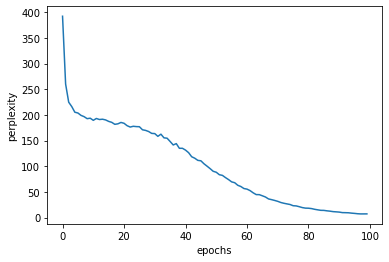

In [13]:
# coding: utf-8
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 
time_size = 5     
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  
ts = corpus[1:]   
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

## 5.5.4 RNNLM의 Trainer 클래스

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.78
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 388.03
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 283.61
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 229.89
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 213.90
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 210.27
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.40
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.16
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 195.10
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 191.63
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.17
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 188.59
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 191.73
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 186.75
| 에폭 15 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 185.37
| 에폭 16 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.00
| 에폭 17 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 188.17
| 에폭 18 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 183.60
| 에폭 19 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 181.41
| 에폭 20 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 182.00
| 에폭 21 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 178.56
| 에폭 22 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 177.

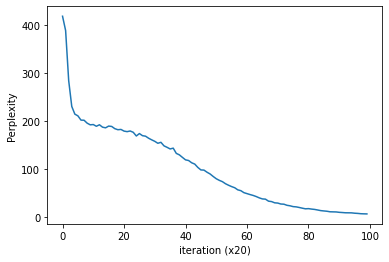

In [14]:
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()